# Uniform Embedding Revisited Distortion

One of the first thing I tried to do while getting into this competition was learn about how how each of the three respective embedding algorithms worked. I wasn't the only one. Another Kaggler you're all familiar with, [@hengck23](https://www.kaggle.com/), also did similarly and published a series of presentations:

- [Understanding from scratch with code: UERD](https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/164184)
- [Understanding from scratch with code: J-MiPOD](https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/164155)
- [Understanding from scratch with code: J-UNIWARD](https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/163992)

In the same light, I'd like to share some of my explorations. Each of the Stegnography algorithms we're working on classifying pretty much operate the same way: A cost-map is built in DCT-space. This cost map is a measure of how 'detectable' +/- 1 value changes are to the source cover image. Depending on how many +/- 1 bit-flips are need to be encoded into the hidden message, a certain number of perturbations are made to cover's DCT. Some algorithms do not gaurantee that the n-"cheapest" DCT perturbations are altered, but that rather only that n-coefficients which have cost less than "K" will be changed. For the record:

- **UERD** Uniform Embedding Revisited Distortion
- **J-MiPOD** Minimizing the Power of Optimal Detector
- **J-UNIWARD** Universal Wavelet Relative Distortion

In this kernel, we'll explore UERD because it's the simplest IMO. The initial MatLab source code we're understanding / porting to Python comes from the [IStego100K: Large-scale Image Steganalysis Dataset](https://github.com/YangzlTHU/IStego100K/tree/master/Steganography) GitHub repository, but can also be found at the [Binghamton University's Steganographic Algorithms](http://dde.binghamton.edu/download/stego_algorithms/) website.

One last note, in the literature, you may often see reference to something called nzACDCT or even nnz. What the heck is that?

By now t-1 day before the competition deadline, you're likely already intimately familiar with [how DCT Coefficients work](https://www.kaggle.com/authman/deep-explorations-with-ubers-jpeg2dct). What's important to note here is that the 0th DCT coefficient is constant along it's entire 8x8 block, which means this coefficient is essentially an offset:

![DCAC DCT](https://www.bogotobogo.com/OpenCV/images/ImageProcessing/DC_AC_Coefficient.png)

In signal processing, one can split a single into a direct-current component (offset from 0) and the actual periodic alternating current component, which is a function of time. In our situation, it's a function of position. We're not dealing with a time based signal, however each AC DCT component perfectly encodes a periodic signal, as demonstrated in [this kernel](https://www.kaggle.com/authman/deep-explorations-with-ubers-jpeg2dct).

For this reason, the 0th DCT component is known as the "DC-Component" and the rest are "AC-Components". The DC component is essentially always non-zero, except in the case where the entire 8x8 image block encoded by the DCT consists only of black pixels. The presense of a non-zero AC component means there is some signal being encoded. DCT is lossless, just like FFT, so if there are 0-value DCT then that signal truly isn't there. On the other hand, any non-zero _ac_ DCT components entail true signal. This is what nnz or nzACDCT means.

# Let's Begin

In [ ]:
!pip install lycon > /dev/null
!git clone https://github.com/dwgoon/jpegio > /dev/null
!pip install ./jpegio/. > /dev/null
!rm -rf jpegio

In [ ]:
# The usual suspects
import pandas as pd
import numpy as np
import jpegio as jio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import lycon
from scipy import ndimage, fftpack
from numpy import matlib as mb
from glob import glob
from tqdm.contrib.concurrent import process_map

In [ ]:
look = lycon.load('../input/alaska2-image-steganalysis/Cover/20015.jpg')
plt.imshow(look)
plt.show()

Our source images are 512x512x3 RGB. We can load them directly into DCT space too, whicch is 512x512x3 YCrBr-DCT Encoded:

In [ ]:
img = jio.read('../input/alaska2-image-steganalysis/Cover/20015.jpg')
ax = plt.subplots(1,3, figsize=(10,5))[1]
ax[0].imshow(img.coef_arrays[0], vmin=-25, vmax=25, cmap='gray'); ax[0].set_title('Y')
ax[1].imshow(img.coef_arrays[1], vmin=-25, vmax=25, cmap='gray'); ax[0].set_title('Cr')
ax[2].imshow(img.coef_arrays[2], vmin=-25, vmax=25, cmap='gray'); ax[0].set_title('Cb')
plt.show()

plt.title('Histogram of DCT Coefficients')
plt.hist(img.coef_arrays[0].flatten(), 100)
plt.show()

That's really not too interesting. Most of the action occurs in the luminance (Y) space. Let's take a look at the difference between this cover's stego:

In [ ]:
simg = jio.read('../input/alaska2-image-steganalysis/UERD/20015.jpg')
ax = plt.subplots(1,3, figsize=(10,5))[1]
ax[0].imshow(img.coef_arrays[0] - simg.coef_arrays[0], cmap='gray')
ax[1].imshow(img.coef_arrays[1] - simg.coef_arrays[1], cmap='gray')
ax[2].imshow(img.coef_arrays[2] - simg.coef_arrays[2], cmap='gray')
plt.show()

plt.hist((img.coef_arrays[0] - simg.coef_arrays[0]).flatten(), 100)
plt.show()

There are only a fewwwww +/- 1 DCT coefficient changes. And at least in this example, 100% of them are in the Y channel. The purpose of this competition is to build intelligent classifiers than can see this change! Talk about a high noise:signal ratio! Let's look at binary images instead for better visibility:

In [ ]:
simg = jio.read('../input/alaska2-image-steganalysis/UERD/20015.jpg')
plt.title(f'{(img.coef_arrays[0] != simg.coef_arrays[0]).sum()} total changed components')
plt.imshow(img.coef_arrays[0] != simg.coef_arrays[0], cmap='gray')
plt.show()

6791 / 512x512x3 is less than one percent. If you even added a noise layer with `p>0.01`, it'd drown out the signal here.

To count the non-zero ***AC*** DCT components, let's first reshape this 512x512 image into 8x8x-1. Once we have it in that format, if we zero out the \[0,0\] component, it'll get rid of all the DC values. We can then simply count the non-zero values to compute the nnz:

# NNZ Calc

In [ ]:
def nz_ac_dct_counts_1d(coef, show=False):
    # Reshape for easy arrangement. In Numpy, reshape and transpose are toll-free.
    # Only the views change, the internal arrangements remain the same:
    simage = coef.reshape(512//8,8,512//8,8).transpose(1,3,0,2).reshape(8,8,-1).copy()
    if show:
        print('Resized Shape:', simage.shape)
    
    # Zero out the DC Components:
    simage[0,0] = 0
    
    # Finally, return the count of the non-zero AC components
    return np.float32((simage != 0).sum())

In [ ]:
nz_ac_dct_counts_1d(img.coef_arrays[0], show=True)

In [ ]:
nz_ac_dct_counts_1d(simg.coef_arrays[0], show=True)

It looks like we picked up a few values. This means in addition to perturbing non-zero DCT coefficients, the UERD embedding algorithm actually converted some previous-zeros to non-zero as well. I guess that makes sense since the data is overwhelming dominated by 0-valued coefficients, as we saw in the figure above titled: "Histogram of DCT Coefficients".

# UERD Cost Calculator

Next, let's code up the heart of the UERD algorithm—it's cost embedder. The way I have it written below is such that it only takes in a single channel at a time; but rewriting it to support multi channel is trivial. The function takes in three inputs. A 2D DCT coefficient array. A quantizer array, which is shaped 8x8. And a wet cost, which you an just consider to be a max cost threshold.

Recall that jpeg compression works so well because many of the higher frequency DCT coefficients are compressed out to 0. After that, the coefficients are listed as a flat 1d array by reorganizing them in zag-zag manner:

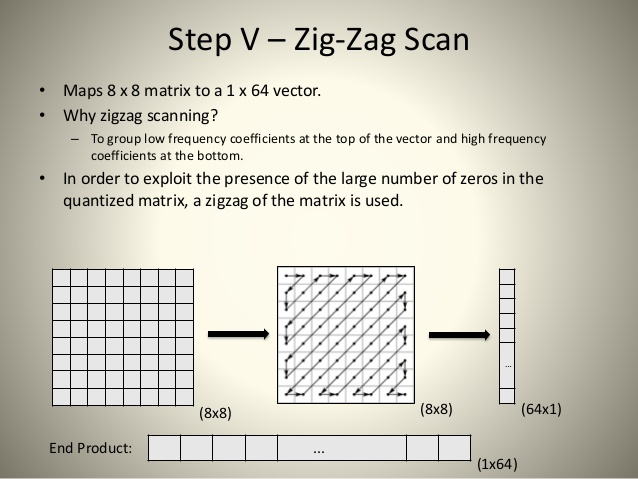

Once the data is in a flat array with mostly zeros at the end, something akin to run-length encoding happens, where all the 0s can be expressed in a very space-conserving format. For example if there are twenty 0's, the program doesn't actually need to store "00000000000000000000", it can just `20x0`. What allows us to compress the values down to zero is the quantization table. Different vendors have their own public formulas for this, and technically, there's nothing stopping you from writing and saving your own into a JPEG file for decoding usage. The quantization table is either a multiplier or a divider for your coefficients. If encoding, then the DCT coefficient values are divided by the quantization table and rounded. If decoding, then the DCT values are multiplied by the quantization table to restore, in a lossy manner, the near-original values. The idea being, most of the values that will be rounded down to zero will be coefficients near the end of the array. For this reason, those coefficients tend to be larger:

In [ ]:
simg.quant_tables[0]

There are two quantization tables stored in each JPEG file. One dedicated to the Y channel, and the other shared by the two color channels. This way, luminance could be compressed different (less) than the color channels, since our eyes are more capable of detecting changes in that space:

In [ ]:
simg.quant_tables[1]

The second quant table has a lot more compression, which will result in more zeros when we divide our DCT coefficients by it. Be sure to pass the right coefficient + quant table pair to the function that calculated uerd costs:

# Show Me Code

In [ ]:
def uerd(coef, quant, wet_cost):
    eps = 1e-7
    row, col = coef.shape
    blk_row = row // 8
    blk_col = col // 8
    
    # Let's use our reshaping trick so that we can take advantage of
    # Numpy broadcasting. That's much better than MatLab than for-loops.
    dct_energy = np.abs(coef).reshape(blk_row,8, blk_col,8).transpose(1,3,0,2).reshape(8, 8, blk_row*blk_col) / quant.reshape(8,8,1)
    
    # Above we calculated the DCT energy the distance from zero / quant table
    # Below we calculate bulk energy, which is the total energy in an 8x8 DCT square:
    blk_energy = dct_energy.sum(axis=(0,1)).reshape(blk_row,blk_col)

    # Think of this mask as a smoothing filter we convolve against
    # the blk_energy computed above
    msk_energy = np.array([
        [0.25, 0.25, 0.25],
        [0.25, 1.00, 0.25],
        [0.25, 0.25, 0.25],
    ])
    blk_energy = ndimage.correlate(blk_energy, msk_energy, mode='nearest').astype(blk_energy.dtype)
    
    # Above we saw blk_energy comes from dct_energy, which has our quant divided out.
    # Now, we're going to put the quant values back into our numerator.
    # Tile the quant tables at every 8x8 square location over the image:
    numerator_unit = quant
    numerator_unit[0,0] = (numerator_unit[0,1] + numerator_unit[1,2]) / 2
    numerator = mb.repmat(numerator_unit, blk_row, blk_col)
    
    # Our denominator is going to be the value of the total energy of the DCT
    # square, expressed into an 8x8 block rather than the per-dct-coefficient (pixel) values:
    denominator = np.ones((8,8,blk_row,blk_col)) * blk_energy.reshape(1,1,blk_row,blk_col)    
    denominator[denominator == 0.0] = 10*eps
    denominator = denominator.transpose(2,0,3,1).reshape(coef.shape)

    # Cool cool cool cool cool cool....
    rho = numerator / denominator
    rho[rho >= wet_cost] = wet_cost
    rho[np.isnan(rho)] = wet_cost
    rho_p1 = rho.copy()
    rho_m1 = rho.copy()

    # We're now thresholded by wet_cost and have two maps.
    # One cost map for plus1 and one for minus one:
    rho_p1[coef > 1023] = wet_cost
    rho_m1[coef < -1023] = wet_cost

    return rho_p1, rho_m1

In [ ]:
WET_COST = 1e10
rho_p1, rho_m1 = uerd(img.coef_arrays[0].copy(), img.quant_tables[0], WET_COST)

(rho_p1 != rho_m1).sum()

Huh? Our + and - 1 costs are identical. Perhaps I messed up with something or perhaps not. Feel free to review my work against [the original implementation](https://github.com/YangzlTHU/IStego100K/blob/master/Steganography/UERD/uerd.m). Let's see what we do have:

In [ ]:
ax = plt.subplots(1,2, sharey=True, sharex=True)[1]
ax[0].imshow(look)
ax[1].imshow(rho_p1, cmap='gray')
plt.show()

Once again, this makes sense. The *smooth* parts of the image, we can't really embed a lot of data in there because it'll be very noticeable. Whereas for the **textured** part of the image, we can stuff a lot of goop in there. In my model error analysis, I've noticed that more blury images tend to be classifier incorrectly as false positives.

I'm actually getting tired of typing up this kernel 😅 and want to watch my model train, so let's power through the rest of this:

In [ ]:
def ternary_entropyf(pP1, pM1):
    eps = 1e-7 # I just choose this value for fp16 safety..
    
    p0 = 1 - pP1 - pM1
    P = np.array([p0, pP1, pM1]).T
    
    H = -P*np.log2(P)
    H[
        (P<eps) |
        (P > 1-eps)
    ] = 0
    return H.sum()

Given two cost probability distributions, that of +1 and that of -1, and an implicit third distribution, which is that of neither of those two, i.e. `1 - (pP1 + pM1)`, we can calculate entropy of the system. Entropy is a logarithmic measure of the number of "states" with significant probability of being occupied:

${\displaystyle S=-k_{\mathrm {B} }\sum _{i}p_{i}\log p_{i},}$

Just assume the Boltzmann constant of porportionality is `1` here.

The following two function handle the actual embedding. The first method takes in our cost maps, our message length, and the total number of elements or number of potential DCT components we have to hide our message it. The second function takes the result of the first, and then actually applies the bit flipping. In this case, we don't actually have any messages to embed, so random noise is just embedded in its stead:

In [ ]:
def calc_lambda(rhoP1, rhoM1, message_length, n):
    l3 = 1e+3
    m3 = message_length + 1
    iterations = 0
    
    while m3 > message_length:
        l3 *= 2
        pP1 = (np.exp(-l3 * rhoP1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        pM1 = (np.exp(-l3 * rhoM1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        
        m3 = ternary_entropyf(pP1, pM1)
        iterations += 1
        if iterations > 10:
            return l3

    l1 = 0
    m1 = n
    lamb = 0

    alpha = message_length / n
    
    # Limit search to 30 iterations and require that relative payload embedded
    # is roughly within 1/1000 of the required relative payload
    while iterations<30 and (m1-m3)/n > alpha/1000:
        lamb = l1 + (l3-l1)*0.5
        pP1 = np.exp(-lamb * rhoP1) / (1 + np.exp(-lamb * rhoP1) + np.exp(-lamb * rhoM1))
        pM1 = np.exp(-lamb * rhoM1) / (1 + np.exp(-lamb * rhoP1) + np.exp(-lamb * rhoM1))
        m2 = ternary_entropyf(pP1, pM1)
        
        if m2 < message_length:
            l3 = lamb
            m3 = m2
                 
        else:
            l1 = lamb
            m1 = m2
                 
        iterations += 1
                 
    return lamb

def pm1_simulator(x, rhoP1, rhoM1, m, seed=42):
    n = x.shape[0] * x.shape[1]
    lamb = calc_lambda(rhoP1, rhoM1, m, n)
    pChangeP1 = np.exp(-lamb * rhoP1) / (1 + np.exp(-lamb * rhoP1) + np.exp(-lamb * rhoM1))
    pChangeM1 = np.exp(-lamb * rhoM1) / (1 + np.exp(-lamb * rhoP1) + np.exp(-lamb * rhoM1))

    np.random.seed(seed)
    randChange = np.random.random(x.shape)
    y = x.copy()
    
    # Take care of the alterations:
    y[randChange < pChangeP1] += 1
    y[
        (randChange >= pChangeP1) &
        (randChange < pChangeP1+pChangeM1)
    ] -= 1
    
    return y

We now have everything we need to do UERD embedding in python:

In [ ]:
def uerd_run(iname, ALPHA):
    WET_COST = 1e10
    js = jio.read(iname)
    coefc = js.coef_arrays[0]
    quant = js.quant_tables[0]
    
    rho_p1, rho_m1 = uerd(coefc, quant, WET_COST)
    coefs = pm1_simulator(coefc, rho_p1, rho_m1, ALPHA*nz_ac_dct_counts_1d(coefc))
    js.coef_arrays[0] = coefs
    return js

We were told by the host that:

> The payload (message length) is adjusted such that the "difficulty" is approximately the same regardless the content of the image. Images with smooth content are used to hide shorter messages while highly textured images will be used to hide more secret bits. The payload is adjusted in the same manner for testing and training sets. The average message length is 0.4 bit per non-zero AC DCT coefficient.

Cool. We don't know how they adjust up or down, so let's just assume 0.4 bp nzACDCT coeff. Actually, let's try a few values and see what the results look like:

In [ ]:
for bpnaACDCT in np.arange(0.1, 0.9, 0.1):
    stego = uerd_run('../input/alaska2-image-steganalysis/UERD/20015.jpg', bpnaACDCT)
    
    # Recall, img is our cover:
    dif = img.coef_arrays[0] != stego.coef_arrays[0]
    plt.figure(figsize=(4,4))
    plt.title(f'Bits Per NZ AC DCT Coeff: {bpnaACDCT}')
    plt.imshow(dif.astype(np.uint8), cmap='gray')
    plt.show()

The more changes we pack in, the more obvious it becomes. Try with other images as well. Lastly, while it probably makes no sense to create a new dataset out of images to train on... perhaps encoding a very minute amount like 0.01 bp nzAC DCT on existing stegno's might not be that bad of an augmentation strategy. At the least, it's smarter than using dropout or gaussian noise. It'll just a a heck of a lot slower.

Good luck with the shakeup everyone, although I doubt there will be much of one. We have a huge dset so it looks like we're going to be seeing a lot of 'trust your cv' writeups shortly. Lastly, in case people are seeing this after the competition, this page [should be your first stop](https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/) for a very comprehensive and easy-to-digest understanding of JPEGs.